In [2]:
# Step 1: Install and import required libraries for our PySpark cryptocurrency analysis project
!pip install pyspark py4j findspark requests matplotlib seaborn pandas

# Initialize Spark in Google Colab
import os
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from datetime import datetime
import time

# Create a Spark session
spark = SparkSession.builder \
    .appName("CryptocurrencyAnalysis") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Display Spark version to verify setup
print(f"Spark version: {spark.version}")

Spark version: 3.5.1


In [3]:
# Step 2: Data collection from CoinMarketCap API

def fetch_crypto_data(api_key, limit=100, convert='USD'):
    """
    Fetch cryptocurrency data from CoinMarketCap API

    Parameters:
    - api_key: Your CoinMarketCap API key
    - limit: Number of cryptocurrencies to fetch (default: 100)
    - convert: Currency to convert prices to (default: USD)

    Returns:
    - Pandas DataFrame with cryptocurrency data
    """
    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'

    parameters = {
        'start': '1',
        'limit': str(limit),
        'convert': convert
    }

    headers = {
        'Accepts': 'application/json',
        'X-CMC_PRO_API_KEY': api_key
    }

    try:
        response = requests.get(url, params=parameters, headers=headers)
        data = json.loads(response.text)
        print(f"API connection successful! Retrieved {len(data['data'])} cryptocurrencies.")

        # Create a list to store normalized data
        crypto_data = []

        for crypto in data['data']:
            # Extract main cryptocurrency information
            crypto_info = {
                'id': crypto['id'],
                'name': crypto['name'],
                'symbol': crypto['symbol'],
                'slug': crypto['slug'],
                'cmc_rank': crypto['cmc_rank'],
                'num_market_pairs': crypto['num_market_pairs'],
                'circulating_supply': crypto['circulating_supply'],
                'total_supply': crypto['total_supply'],
                'max_supply': crypto['max_supply'] if crypto['max_supply'] else 0,
                'infinite_supply': crypto['infinite_supply'],
                'last_updated': crypto['last_updated'],
                'date_added': crypto['date_added']
            }

            # Extract USD-specific pricing data
            usd_data = crypto['quote']['USD']
            for key, value in usd_data.items():
                crypto_info[f'{key}'] = value

            # Add timestamp for data collection time
            crypto_info['collection_timestamp'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            crypto_data.append(crypto_info)

        # Create pandas DataFrame
        df = pd.DataFrame(crypto_data)

        return df

    except (requests.exceptions.ConnectionError,
            requests.exceptions.Timeout,
            requests.exceptions.TooManyRedirects) as e:
        print(f"API Error: {e}")
        return None


API_KEY = "7c04ab0d-2545-4405-8fc7-d575f4a0e55d"

# limit for testing
crypto_df = fetch_crypto_data(API_KEY, limit=100)

# Show the first few rows to verify the data
if crypto_df is not None:
    print("\nDataFrame Shape:", crypto_df.shape)
    print("\nColumns:", crypto_df.columns.tolist())
    print("\nSample Data:")
    display(crypto_df.head(3))

API connection successful! Retrieved 100 cryptocurrencies.

DataFrame Shape: (100, 26)

Columns: ['id', 'name', 'symbol', 'slug', 'cmc_rank', 'num_market_pairs', 'circulating_supply', 'total_supply', 'max_supply', 'infinite_supply', 'last_updated', 'date_added', 'price', 'volume_24h', 'volume_change_24h', 'percent_change_1h', 'percent_change_24h', 'percent_change_7d', 'percent_change_30d', 'percent_change_60d', 'percent_change_90d', 'market_cap', 'market_cap_dominance', 'fully_diluted_market_cap', 'tvl', 'collection_timestamp']

Sample Data:


,id,name,symbol,slug,cmc_rank,num_market_pairs,circulating_supply,total_supply,max_supply,infinite_supply,...,percent_change_24h,percent_change_7d,percent_change_30d,percent_change_60d,percent_change_90d,market_cap,market_cap_dominance,fully_diluted_market_cap,tvl,collection_timestamp
0,1,Bitcoin,BTC,bitcoin,1,12063,1.986394e+07,1.986394e+07,21000000.0,False,...,-0.903688,8.354442,20.670857,26.658967,7.729167,2.045372e+12,61.6834,2.162351e+12,NaN,2025-05-12 23:06:15
1,1027,Ethereum,ETH,ethereum,2,10289,1.207297e+08,1.207297e+08,0.0,True,...,-0.682777,36.465978,51.047482,32.821344,-3.940334,3.007800e+11,9.0725,3.007800e+11,NaN,2025-05-12 23:06:15
2,825,Tether USDt,USDT,tether,3,127484,1.500566e+11,1.535083e+11,0.0,True,...,-0.017932,-0.004223,0.025721,0.057904,0.013015,1.500595e+11,4.5257,1.535113e+11,NaN,2025-05-12 23:06:15


In [4]:
# Step 3: Convert pandas DataFrame to PySpark DataFrame and perform initial data processing

# Convert pandas DataFrame to PySpark DataFrame
spark_df = spark.createDataFrame(crypto_df)

# Display schema and basic information
print("PySpark DataFrame Schema:")
spark_df.printSchema()

# Basic data profiling
print("\nDataFrame Summary:")
print(f"Number of records: {spark_df.count()}")
print(f"Number of columns: {len(spark_df.columns)}")

# Display basic statistics for numerical columns
print("\nNumerical Column Statistics:")
numeric_stats = spark_df.select([
    'price', 'volume_24h', 'percent_change_1h', 'percent_change_24h',
    'percent_change_7d', 'market_cap', 'circulating_supply'
]).describe()
display(numeric_stats)

# Feature Engineering: Create new features for analysis
spark_df = spark_df.withColumn(
    "volume_to_market_cap_ratio",
    F.col("volume_24h") / F.col("market_cap")
).withColumn(
    "price_to_mc_per_circ_supply",
    F.col("price") / (F.col("market_cap") / F.col("circulating_supply"))
).withColumn(
    "volatility_indicator",
    F.abs(F.col("percent_change_24h")) + F.abs(F.col("percent_change_7d"))
).withColumn(
    "market_maturity",
    F.datediff(F.current_timestamp(), F.to_timestamp(F.col("date_added")))
).withColumn(
    "price_category",
    F.when(F.col("price") < 1, "penny").
    when(F.col("price") < 10, "low").
    when(F.col("price") < 100, "medium").
    when(F.col("price") < 1000, "high").
    otherwise("premium")
).withColumn(
    "volume_category",
    F.when(F.col("volume_24h") < 1000000, "very_low").
    when(F.col("volume_24h") < 10000000, "low").
    when(F.col("volume_24h") < 100000000, "medium").
    when(F.col("volume_24h") < 1000000000, "high").
    otherwise("very_high")
)

# Validate new columns
print("\nSchema after Feature Engineering:")
spark_df.printSchema()

# Show sample with new features
print("\nSample Data with New Features:")
display(spark_df.select(
    "name", "symbol", "price", "market_cap", "volume_24h",
    "percent_change_24h", "volume_to_market_cap_ratio",
    "volatility_indicator", "market_maturity", "price_category", "volume_category"
).limit(5))

# Cache the DataFrame for faster processing
spark_df.cache()

PySpark DataFrame Schema:
root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- slug: string (nullable = true)
 |-- cmc_rank: long (nullable = true)
 |-- num_market_pairs: long (nullable = true)
 |-- circulating_supply: double (nullable = true)
 |-- total_supply: double (nullable = true)
 |-- max_supply: double (nullable = true)
 |-- infinite_supply: boolean (nullable = true)
 |-- last_updated: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- price: double (nullable = true)
 |-- volume_24h: double (nullable = true)
 |-- volume_change_24h: double (nullable = true)
 |-- percent_change_1h: double (nullable = true)
 |-- percent_change_24h: double (nullable = true)
 |-- percent_change_7d: double (nullable = true)
 |-- percent_change_30d: double (nullable = true)
 |-- percent_change_60d: double (nullable = true)
 |-- percent_change_90d: double (nullable = true)
 |-- market_cap: double (nullable = true)
 |-- 

DataFrame[summary: string, price: string, volume_24h: string, percent_change_1h: string, percent_change_24h: string, percent_change_7d: string, market_cap: string, circulating_supply: string]


Schema after Feature Engineering:
root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- slug: string (nullable = true)
 |-- cmc_rank: long (nullable = true)
 |-- num_market_pairs: long (nullable = true)
 |-- circulating_supply: double (nullable = true)
 |-- total_supply: double (nullable = true)
 |-- max_supply: double (nullable = true)
 |-- infinite_supply: boolean (nullable = true)
 |-- last_updated: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- price: double (nullable = true)
 |-- volume_24h: double (nullable = true)
 |-- volume_change_24h: double (nullable = true)
 |-- percent_change_1h: double (nullable = true)
 |-- percent_change_24h: double (nullable = true)
 |-- percent_change_7d: double (nullable = true)
 |-- percent_change_30d: double (nullable = true)
 |-- percent_change_60d: double (nullable = true)
 |-- percent_change_90d: double (nullable = true)
 |-- market_cap: double (nullable = tr

DataFrame[name: string, symbol: string, price: double, market_cap: double, volume_24h: double, percent_change_24h: double, volume_to_market_cap_ratio: double, volatility_indicator: double, market_maturity: int, price_category: string, volume_category: string]

DataFrame[id: bigint, name: string, symbol: string, slug: string, cmc_rank: bigint, num_market_pairs: bigint, circulating_supply: double, total_supply: double, max_supply: double, infinite_supply: boolean, last_updated: string, date_added: string, price: double, volume_24h: double, volume_change_24h: double, percent_change_1h: double, percent_change_24h: double, percent_change_7d: double, percent_change_30d: double, percent_change_60d: double, percent_change_90d: double, market_cap: double, market_cap_dominance: double, fully_diluted_market_cap: double, tvl: double, collection_timestamp: string, volume_to_market_cap_ratio: double, price_to_mc_per_circ_supply: double, volatility_indicator: double, market_maturity: int, price_category: string, volume_category: string]

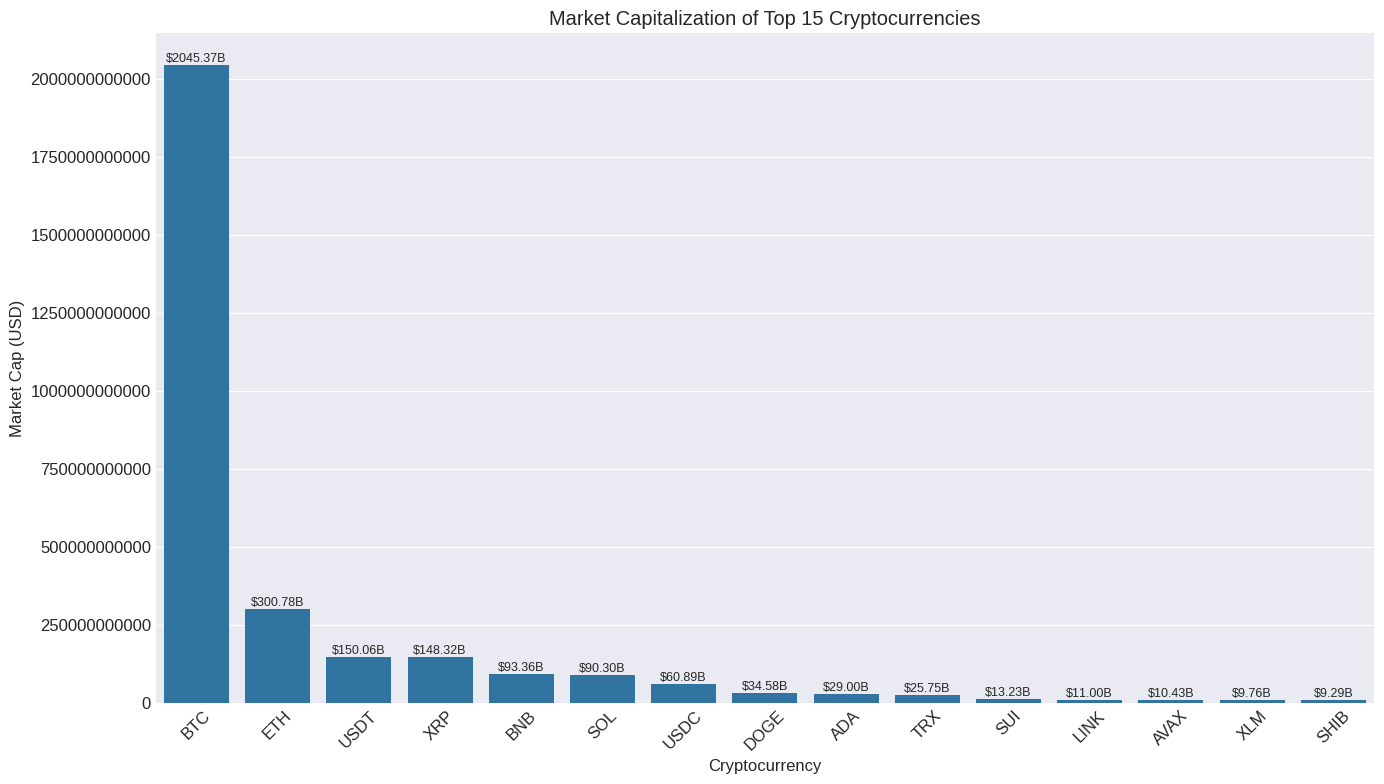

In [5]:
# Step 4: Exploratory Data Analysis (EDA) with PySpark and visualization

# Convert to pandas for visualization
pd_df = spark_df.toPandas()

# Set up the visualization environment
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# 1. Market Cap Distribution - Top 15 cryptocurrencies
plt.figure(figsize=(14, 8))
top_15_by_mc = pd_df.sort_values('market_cap', ascending=False).head(15)
sns.barplot(x='symbol', y='market_cap', data=top_15_by_mc)
plt.title('Market Capitalization of Top 15 Cryptocurrencies')
plt.xlabel('Cryptocurrency')
plt.ylabel('Market Cap (USD)')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
# Add values on top of bars with appropriate formatting
for i, v in enumerate(top_15_by_mc['market_cap']):
    if v >= 1e9:  # If value is in billions
        formatted_value = f"${v/1e9:.2f}B"
    else:  # If value is in millions
        formatted_value = f"${v/1e6:.2f}M"
    plt.text(i, v, formatted_value, ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


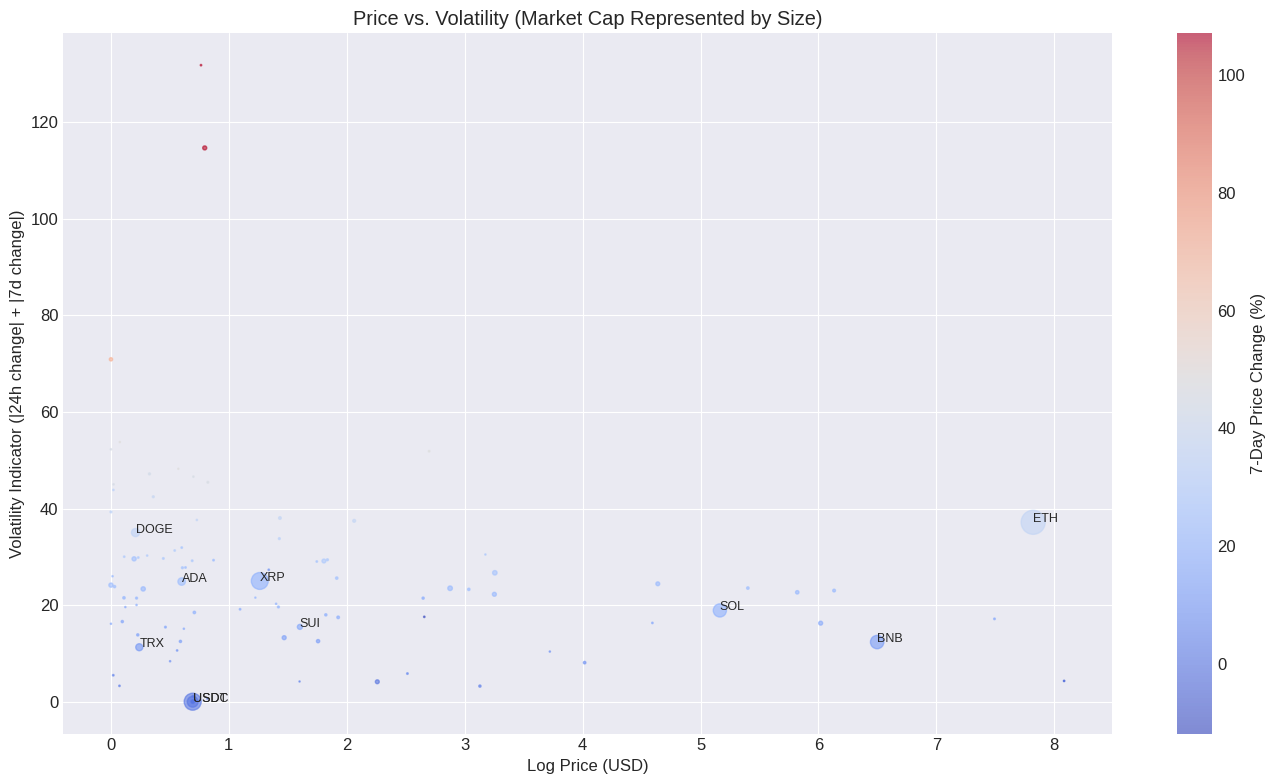

In [6]:

# 2. Price vs. Volatility scatter plot with size representing market cap
plt.figure(figsize=(14, 8))
# Focus on cryptocurrencies with price < $10,000 for better visualization
filtered_df = pd_df[pd_df['price'] < 10000].copy()
# Create a logarithmic scale for price for better visualization
filtered_df['log_price'] = np.log1p(filtered_df['price'])
# Create a scatter plot with log price on x-axis, volatility on y-axis, and market cap for sizing
scatter = plt.scatter(
    filtered_df['log_price'],
    filtered_df['volatility_indicator'],
    s=filtered_df['market_cap'] / 1e9,  # Size based on market cap (in billions)
    alpha=0.6,
    c=filtered_df['percent_change_7d'],  # Color based on 7-day change
    cmap='coolwarm'
)
plt.colorbar(scatter, label='7-Day Price Change (%)')
plt.title('Price vs. Volatility (Market Cap Represented by Size)')
plt.xlabel('Log Price (USD)')
plt.ylabel('Volatility Indicator (|24h change| + |7d change|)')
# Annotate points for the top 10 cryptocurrencies by market cap
for i, row in filtered_df.sort_values('market_cap', ascending=False).head(10).iterrows():
    plt.annotate(
        row['symbol'],
        (row['log_price'], row['volatility_indicator']),
        fontsize=9
    )
plt.tight_layout()
plt.show()

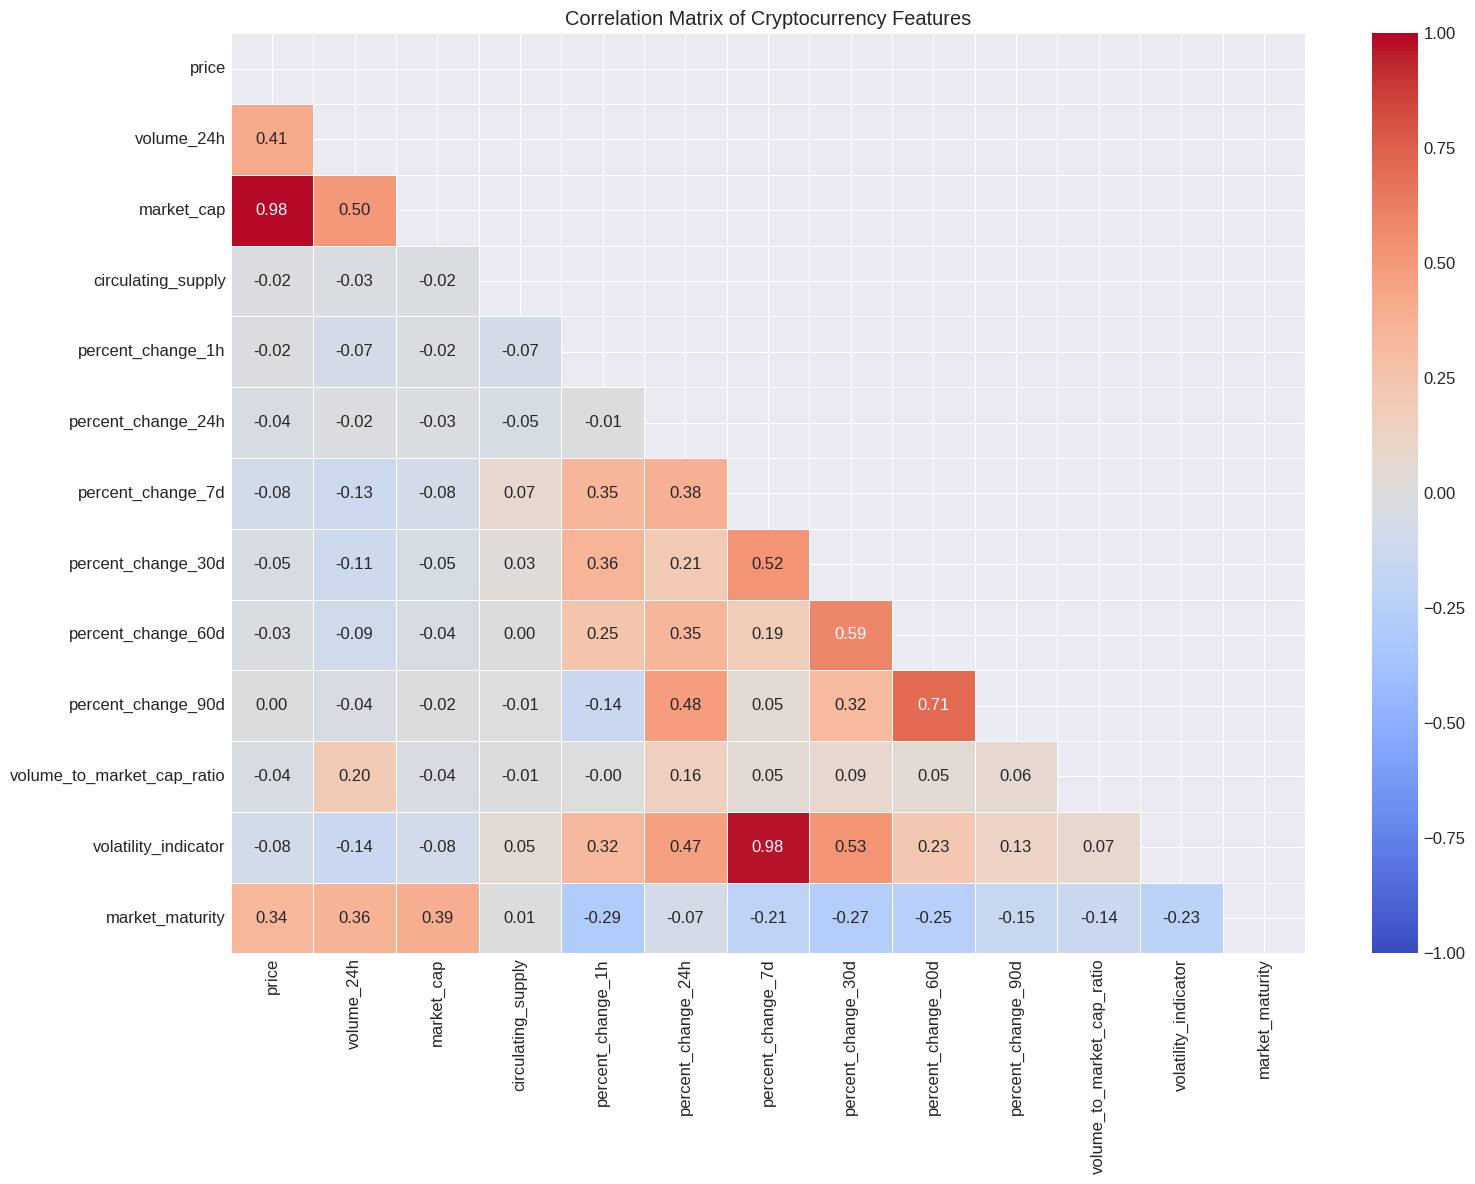

In [7]:

# 3. Correlation heatmap for numerical features
plt.figure(figsize=(16, 12))
# Select numerical columns for correlation analysis
num_cols = [
    'price', 'volume_24h', 'market_cap', 'circulating_supply',
    'percent_change_1h', 'percent_change_24h', 'percent_change_7d',
    'percent_change_30d', 'percent_change_60d', 'percent_change_90d',
    'volume_to_market_cap_ratio', 'volatility_indicator', 'market_maturity'
]
corr_matrix = pd_df[num_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linewidths=0.5
)
plt.title('Correlation Matrix of Cryptocurrency Features')
plt.tight_layout()
plt.show()

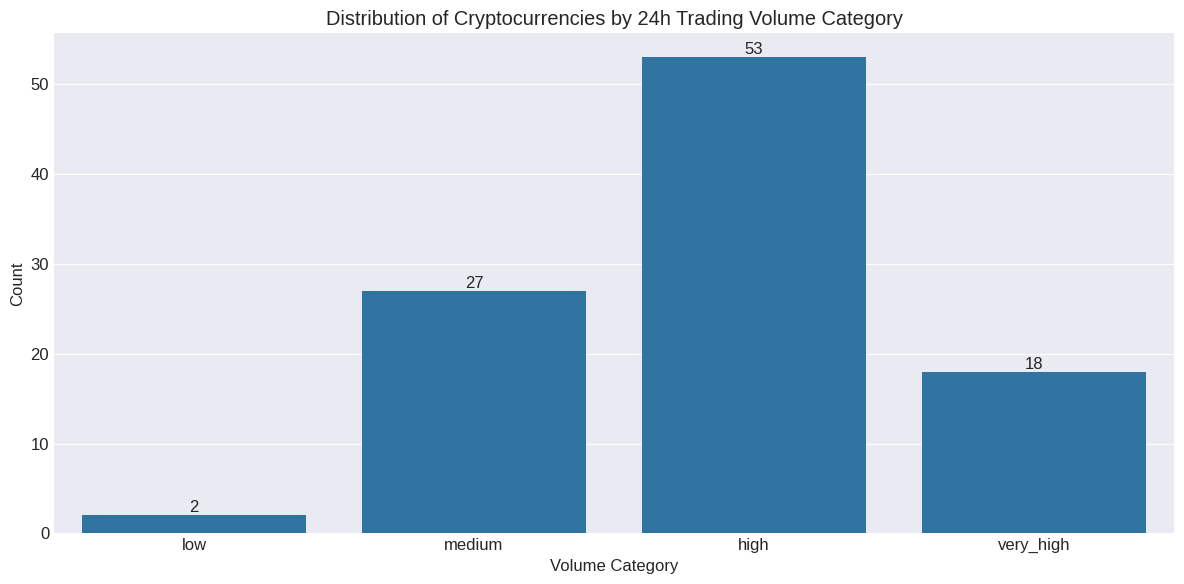

In [8]:

# 4. 24-hour Volume Distribution by Volume Category
plt.figure(figsize=(12, 6))
volume_counts = pd_df['volume_category'].value_counts().sort_index(
    key=lambda x: pd.Categorical(
        x, categories=['very_low', 'low', 'medium', 'high', 'very_high'],
        ordered=True
    )
)
sns.barplot(x=volume_counts.index, y=volume_counts.values)
plt.title('Distribution of Cryptocurrencies by 24h Trading Volume Category')
plt.xlabel('Volume Category')
plt.ylabel('Count')
for i, v in enumerate(volume_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()

<ipython-input-9-0a544c6e6fba>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Time Period', y='Percent Change', data=change_data, palette='viridis')


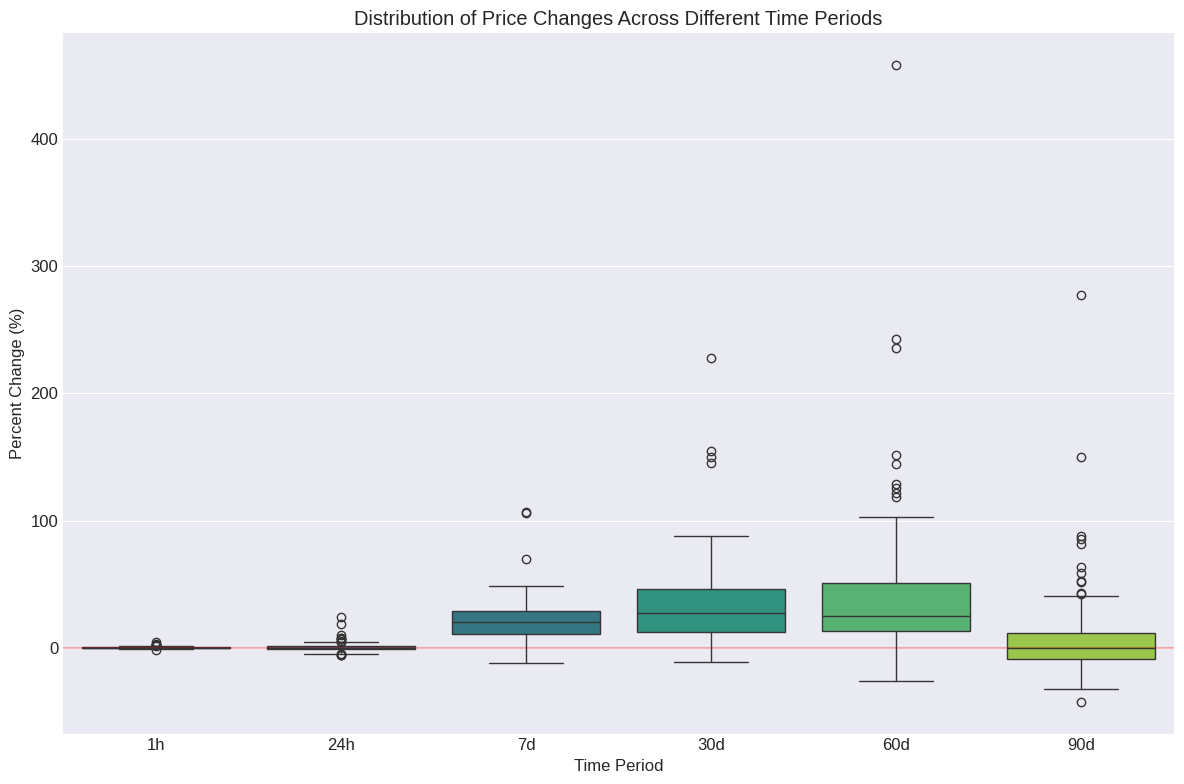

In [9]:

# 5. Price Change Comparison (Box Plot)
plt.figure(figsize=(12, 8))
change_cols = ['percent_change_1h', 'percent_change_24h', 'percent_change_7d',
              'percent_change_30d', 'percent_change_60d', 'percent_change_90d']
change_data = pd.melt(pd_df, value_vars=change_cols, var_name='Time Period', value_name='Percent Change')
# Improve readability of time period labels
change_data['Time Period'] = change_data['Time Period'].str.replace('percent_change_', '')
time_order = ['1h', '24h', '7d', '30d', '60d', '90d']
change_data['Time Period'] = pd.Categorical(change_data['Time Period'], categories=time_order, ordered=True)
sns.boxplot(x='Time Period', y='Percent Change', data=change_data, palette='viridis')
plt.title('Distribution of Price Changes Across Different Time Periods')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.ylabel('Percent Change (%)')
plt.tight_layout()
plt.show()


In [10]:
# Analytical insights
print("\n=== Key Analytical Insights ===")
# Top performers in 24h
print("\nTop 5 Performers (24h change):")
display(pd_df[['name', 'symbol', 'price', 'percent_change_24h']].sort_values('percent_change_24h', ascending=False).head(5))



=== Key Analytical Insights ===

Top 5 Performers (24h change):


,name,symbol,price,percent_change_24h
73,dogwifhat,WIF,1.146134,24.660627
76,Four,FORM,2.812813,18.851352
77,JasmyCoin,JASMY,0.020925,10.290987
16,Pi,PI,1.214955,8.141716
75,FLOKI,FLOKI,0.000112,8.008294


In [11]:

# Worst performers in 24h
print("\nWorst 5 Performers (24h change):")
display(pd_df[['name', 'symbol', 'price', 'percent_change_24h']].sort_values('percent_change_24h').head(5))



Worst 5 Performers (24h change):


,name,symbol,price,percent_change_24h
74,DeXe,DEXE,13.257200,-5.740721
95,Brett (Based),BRETT,0.078263,-5.308874
64,Optimism,OP,0.822444,-5.179423
44,OFFICIAL TRUMP,TRUMP,13.117699,-4.875196
45,Ethena,ENA,0.386290,-4.513233


In [12]:
# Most volatile cryptocurrencies
print("\nMost Volatile Cryptocurrencies:")
display(pd_df[['name', 'symbol', 'volatility_indicator', 'percent_change_24h', 'percent_change_7d']].sort_values('volatility_indicator', ascending=False).head(5))



Most Volatile Cryptocurrencies:


,name,symbol,volatility_indicator,percent_change_24h,percent_change_7d
73,dogwifhat,WIF,131.739433,24.660627,107.078806
16,Pi,PI,114.615478,8.141716,106.473762
24,Pepe,PEPE,70.868311,-0.828269,70.040042
95,Brett (Based),BRETT,53.748293,-5.308874,48.439419
75,FLOKI,FLOKI,52.248516,8.008294,44.240222


In [13]:
# Volume to market cap ratio (high liquidity relative to size)
print("\nHighest Volume-to-Market Cap Ratio (Liquidity indicator):")
display(pd_df[['name', 'symbol', 'volume_to_market_cap_ratio', 'market_cap', 'volume_24h']].sort_values('volume_to_market_cap_ratio', ascending=False).head(5))


Highest Volume-to-Market Cap Ratio (Liquidity indicator):


,name,symbol,volume_to_market_cap_ratio,market_cap,volume_24h
26,Dai,DAI,3.141478,5.365410e+09,1.685532e+10
57,First Digital USD,FDUSD,3.042623,1.515327e+09,4.610571e+09
73,dogwifhat,WIF,1.602786,1.144805e+09,1.834877e+09
44,OFFICIAL TRUMP,TRUMP,0.912338,2.623532e+09,2.393549e+09
2,Tether USDt,USDT,0.866576,1.500595e+11,1.300379e+11


In [14]:
# Step 5 (Revised): Handle data types properly for machine learning preparation

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.sql.functions import col, isnan, when, count, lit, isnull
from pyspark.sql.types import DoubleType, FloatType, IntegerType, LongType

# Function to check for nulls that respects data types
def check_nulls_by_type(df):
    """Check for null values in a DataFrame, accounting for different data types."""
    result = {}

    # Get schema information
    schema = df.schema

    # Process each column based on its type
    for field in schema.fields:
        col_name = field.name
        col_type = field.dataType

        # For numeric types, check both NULL and NaN
        if isinstance(col_type, (DoubleType, FloatType)):
            null_count = df.filter(col(col_name).isNull() | isnan(col(col_name))).count()
        else:
            # For non-numeric types, only check NULL
            null_count = df.filter(col(col_name).isNull()).count()

        if null_count > 0:
            result[col_name] = null_count

    return result

# Check for null values
print("Checking for null values in the dataset:")
null_values = check_nulls_by_type(spark_df)
if null_values:
    print("Columns with null values:")
    for col_name, null_count in null_values.items():
        print(f"  {col_name}: {null_count} null values")
else:
    print("No null values found in the dataset.")

# Modified data preparation function
def prepare_ml_data_revised(spark_df, target_col=None, categorical_cols=None, exclude_cols=None):
    """
    Prepare a PySpark DataFrame for machine learning with proper type handling.

    Parameters:
    - spark_df: The input PySpark DataFrame
    - target_col: The target column for supervised learning (if applicable)
    - categorical_cols: List of categorical columns to convert
    - exclude_cols: List of columns to exclude from features

    Returns:
    - Prepared DataFrame with features column
    """
    # Make a copy of the DataFrame
    df = spark_df

    # Set default values if not provided
    if categorical_cols is None:
        categorical_cols = []

    if exclude_cols is None:
        exclude_cols = []

    if target_col is not None and target_col not in exclude_cols:
        exclude_cols.append(target_col)

    # Get schema information
    schema = df.schema
    numeric_columns = []
    string_columns = []
    boolean_columns = []

    # Categorize columns by data type
    for field in schema.fields:
        col_name = field.name
        if col_name in exclude_cols:
            continue

        col_type = field.dataType
        if isinstance(col_type, (DoubleType, FloatType, IntegerType, LongType)):
            numeric_columns.append(col_name)
        elif col_type.typeName() == "string":
            string_columns.append(col_name)
        elif col_type.typeName() == "boolean":
            boolean_columns.append(col_name)

    # Handle missing values for numeric columns
    for col_name in numeric_columns:
        if isinstance(schema[col_name].dataType, (DoubleType, FloatType)):
            # For double/float, handle both NULL and NaN
            df = df.withColumn(col_name,
                              when(col(col_name).isNull() | isnan(col(col_name)), 0.0)
                              .otherwise(col(col_name)))
        else:
            # For other numeric types, handle only NULL
            df = df.withColumn(col_name,
                              when(col(col_name).isNull(), 0)
                              .otherwise(col(col_name)))

    # Convert boolean columns to numeric
    for col_name in boolean_columns:
        if col_name not in exclude_cols:
            df = df.withColumn(f"{col_name}_numeric", col(col_name).cast("double"))
            numeric_columns.append(f"{col_name}_numeric")

    # Convert categorical columns to numeric using StringIndexer
    indexed_cols = []
    for cat_col in categorical_cols:
        if cat_col not in exclude_cols and cat_col in df.columns:
            indexer = StringIndexer(inputCol=cat_col, outputCol=f"{cat_col}_idx", handleInvalid="keep")
            df = indexer.fit(df).transform(df)
            indexed_cols.append(f"{cat_col}_idx")

    # Create feature vector
    feature_cols = [col for col in numeric_columns if col not in exclude_cols]
    feature_cols.extend(indexed_cols)

    print(f"Using {len(feature_cols)} features for the model: {feature_cols}")

    # Create feature vector with options to handle invalid values
    assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol="features",
        handleInvalid="skip"  # Skip invalid values
    )
    df = assembler.transform(df)

    return df, feature_cols

# 1. Regression dataset - predicting 7-day price change
print("\nPreparing regression dataset for price prediction...")
regression_exclude = ['id', 'name', 'symbol', 'slug', 'last_updated', 'date_added',
                      'collection_timestamp', 'infinite_supply',
                      'percent_change_1h', 'percent_change_30d', 'percent_change_60d',
                      'percent_change_90d', 'tvl']
regression_target = 'percent_change_7d'
regression_df, regression_features = prepare_ml_data_revised(
    spark_df,
    target_col=regression_target,
    categorical_cols=['price_category', 'volume_category'],
    exclude_cols=regression_exclude
)

# Check if features were created successfully
feature_null_count = regression_df.filter(col("features").isNull()).count()
print(f"Rows with null feature vectors: {feature_null_count}")

# Split regression data
regression_train, regression_test = regression_df.randomSplit([0.8, 0.2], seed=42)
print(f"Regression training set size: {regression_train.count()}")
print(f"Regression test set size: {regression_test.count()}")

# Show a sample of the regression data
print("\nSample regression data with features:")
display(regression_df.select("name", "symbol", regression_target, "features").limit(3))

# Proceed with classification and clustering only if regression was successful
if feature_null_count == 0:
    # 2. Classification dataset - predicting price category
    print("\nPreparing classification dataset for price category prediction...")
    classification_exclude = ['id', 'name', 'symbol', 'slug', 'last_updated', 'date_added',
                              'collection_timestamp', 'price', 'infinite_supply',
                              'price_category', 'percent_change_1h', 'percent_change_30d', 'tvl']
    classification_target = 'price_category'
    classification_df, classification_features = prepare_ml_data_revised(
        spark_df,
        target_col=classification_target,
        categorical_cols=['volume_category'],
        exclude_cols=classification_exclude
    )

    # Convert target to index for classification
    price_indexer = StringIndexer(inputCol="price_category", outputCol="price_category_idx", handleInvalid="keep").fit(classification_df)
    classification_df = price_indexer.transform(classification_df)

    # Split classification data
    classification_train, classification_test = classification_df.randomSplit([0.8, 0.2], seed=42)
    print(f"Classification training set size: {classification_train.count()}")
    print(f"Classification test set size: {classification_test.count()}")
    # 2) **NEW**: build a mapping from index → original label
    category_mapping = {
        idx: label
        for idx, label in enumerate(price_indexer.labels)
    }

    # 3. Clustering dataset - for market pattern identification
    print("\nPreparing clustering dataset for market pattern identification...")
    clustering_exclude = ['id', 'name', 'symbol', 'slug', 'last_updated', 'date_added',
                          'collection_timestamp', 'infinite_supply',
                          'price_category', 'volume_category', 'tvl']
    clustering_df, clustering_features = prepare_ml_data_revised(
        spark_df,
        categorical_cols=[],
        exclude_cols=clustering_exclude
    )

    # Standardize features for clustering
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
    scaler_model = scaler.fit(clustering_df)
    clustering_df = scaler_model.transform(clustering_df)

    print(f"Clustering dataset size: {clustering_df.count()}")
    print(f"Number of features for clustering: {len(clustering_features)}")

    # Sample data for verification
    print("\nSample classification data:")
    display(classification_df.select("name", "symbol", classification_target, "price_category_idx", "features").limit(3))

    print("\nSample clustering data:")
    display(clustering_df.select("name", "symbol", "features", "scaled_features").limit(3))
else:
    print("\nSkipping classification and clustering preparation due to issues with regression dataset.")

Checking for null values in the dataset:
Columns with null values:
  tvl: 92 null values

Preparing regression dataset for price prediction...
Using 18 features for the model: ['cmc_rank', 'num_market_pairs', 'circulating_supply', 'total_supply', 'max_supply', 'price', 'volume_24h', 'volume_change_24h', 'percent_change_24h', 'market_cap', 'market_cap_dominance', 'fully_diluted_market_cap', 'volume_to_market_cap_ratio', 'price_to_mc_per_circ_supply', 'volatility_indicator', 'market_maturity', 'price_category_idx', 'volume_category_idx']
Rows with null feature vectors: 0
Regression training set size: 77
Regression test set size: 23

Sample regression data with features:


DataFrame[name: string, symbol: string, percent_change_7d: double, features: vector]


Preparing classification dataset for price category prediction...
Using 19 features for the model: ['cmc_rank', 'num_market_pairs', 'circulating_supply', 'total_supply', 'max_supply', 'volume_24h', 'volume_change_24h', 'percent_change_24h', 'percent_change_7d', 'percent_change_60d', 'percent_change_90d', 'market_cap', 'market_cap_dominance', 'fully_diluted_market_cap', 'volume_to_market_cap_ratio', 'price_to_mc_per_circ_supply', 'volatility_indicator', 'market_maturity', 'volume_category_idx']
Classification training set size: 77
Classification test set size: 23

Preparing clustering dataset for market pattern identification...
Using 21 features for the model: ['cmc_rank', 'num_market_pairs', 'circulating_supply', 'total_supply', 'max_supply', 'price', 'volume_24h', 'volume_change_24h', 'percent_change_1h', 'percent_change_24h', 'percent_change_7d', 'percent_change_30d', 'percent_change_60d', 'percent_change_90d', 'market_cap', 'market_cap_dominance', 'fully_diluted_market_cap', 'volu

DataFrame[name: string, symbol: string, price_category: string, price_category_idx: double, features: vector]


Sample clustering data:


DataFrame[name: string, symbol: string, features: vector, scaled_features: vector]

In [15]:
# Step 6: Implement Machine Learning Models

# 1. Regression Model for 7-day Price Change Prediction
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

print("=== 1. Cryptocurrency Price Change Prediction (Regression) ===")

# Random Forest Regressor
print("\nBuilding Random Forest Regression model...")
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol=regression_target,
    numTrees=100,
    maxDepth=10,
    seed=42
)

# Train the model
rf_model = rf.fit(regression_train)

# Make predictions
rf_predictions = rf_model.transform(regression_test)

# Evaluate the model
rf_evaluator = RegressionEvaluator(
    labelCol=regression_target,
    predictionCol="prediction",
    metricName="rmse"
)
rf_rmse = rf_evaluator.evaluate(rf_predictions)
rf_r2 = RegressionEvaluator(
    labelCol=regression_target,
    predictionCol="prediction",
    metricName="r2"
).evaluate(rf_predictions)

print(f"Random Forest Regression Results:")
print(f"  RMSE: {rf_rmse:.4f}")
print(f"  R²: {rf_r2:.4f}")

# Let's try Linear Regression as a baseline model
print("\nBuilding Linear Regression model...")
lr = LinearRegression(
    featuresCol="features",
    labelCol=regression_target,
    maxIter=10,
    regParam=0.1
)

# Train the model
lr_model = lr.fit(regression_train)

# Make predictions
lr_predictions = lr_model.transform(regression_test)

=== 1. Cryptocurrency Price Change Prediction (Regression) ===

Building Random Forest Regression model...
Random Forest Regression Results:
  RMSE: 6.6730
  R²: 0.6927

Building Linear Regression model...


In [16]:
# Evaluate Linear Regression
lr_rmse = rf_evaluator.evaluate(lr_predictions)
lr_r2 = RegressionEvaluator(
    labelCol=regression_target,
    predictionCol="prediction",
    metricName="r2"
).evaluate(lr_predictions)

print(f"Linear Regression Results:")
print(f"  RMSE: {lr_rmse:.4f}")
print(f"  R²: {lr_r2:.4f}")

# Feature Importance (for Random Forest)
feature_importances = [(feature, importance)
                       for feature, importance in zip(regression_features, rf_model.featureImportances)]
print("\nFeature Importances (Random Forest):")
for feature, importance in sorted(feature_importances, key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {feature}: {importance:.4f}")

# Display sample predictions for comparison
print("\nSample Predictions vs Actual Values:")
sample_results = rf_predictions.select(
    "name", "symbol", regression_target, "prediction"
).limit(10)
display(sample_results)

Linear Regression Results:
  RMSE: 3.1067
  R²: 0.9334

Feature Importances (Random Forest):
  volatility_indicator: 0.4510
  num_market_pairs: 0.0805
  percent_change_24h: 0.0762
  volume_to_market_cap_ratio: 0.0748
  volume_24h: 0.0562
  market_maturity: 0.0347
  volume_change_24h: 0.0334
  max_supply: 0.0307
  price: 0.0237
  cmc_rank: 0.0235

Sample Predictions vs Actual Values:


DataFrame[name: string, symbol: string, percent_change_7d: double, prediction: double]

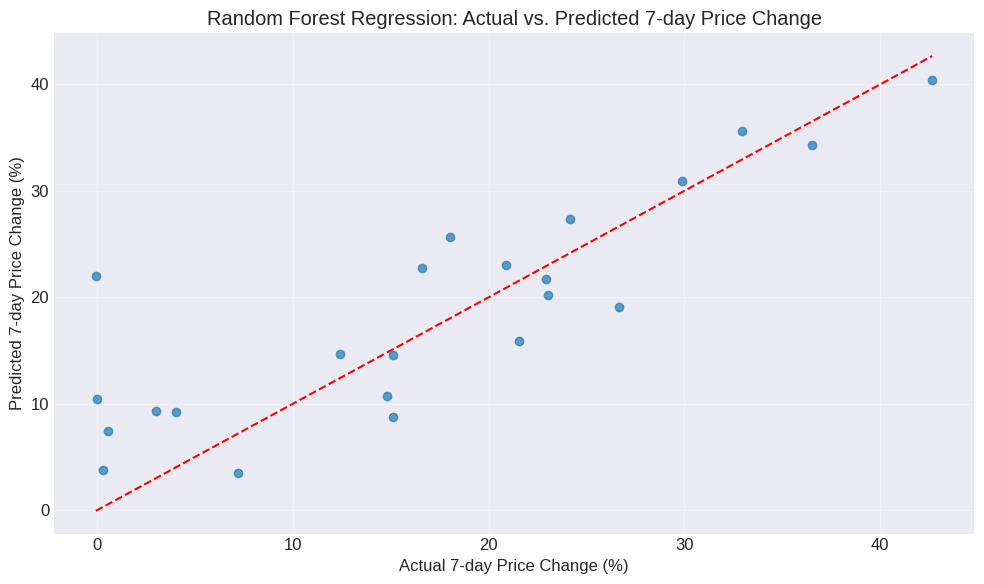

In [17]:

# Let's also visualize the predictions in a Pandas DataFrame
import matplotlib.pyplot as plt
import numpy as np

# Convert to Pandas for visualization
prediction_df = rf_predictions.select(
    "name", "symbol", regression_target, "prediction"
).toPandas()

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(prediction_df[regression_target], prediction_df["prediction"], alpha=0.7)
plt.plot(
    [prediction_df[regression_target].min(), prediction_df[regression_target].max()],
    [prediction_df[regression_target].min(), prediction_df[regression_target].max()],
    'r--'
)
plt.xlabel('Actual 7-day Price Change (%)')
plt.ylabel('Predicted 7-day Price Change (%)')
plt.title('Random Forest Regression: Actual vs. Predicted 7-day Price Change')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


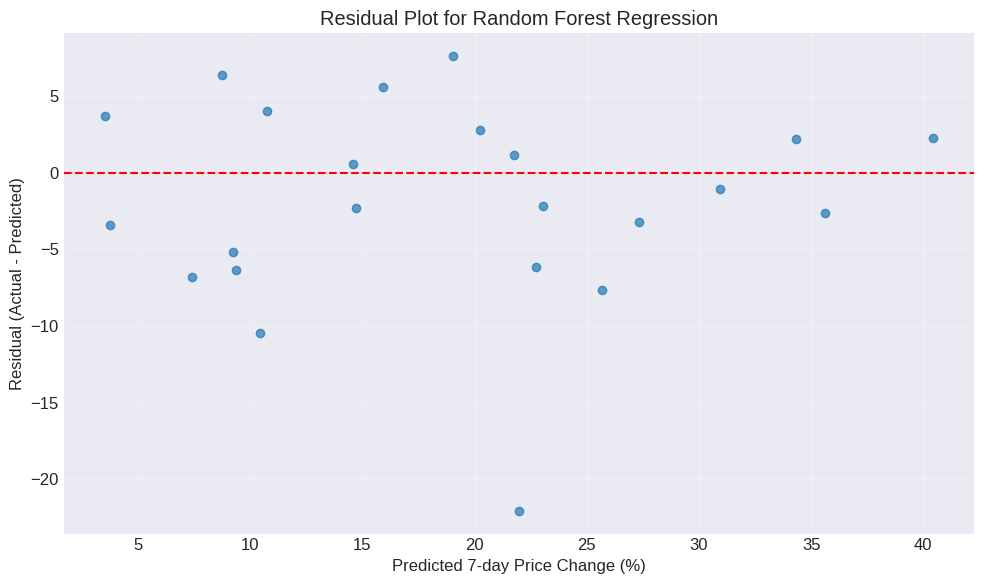

In [18]:
# Also visualize the residuals
plt.figure(figsize=(10, 6))
residuals = prediction_df[regression_target] - prediction_df["prediction"]
plt.scatter(prediction_df["prediction"], residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted 7-day Price Change (%)')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot for Random Forest Regression')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
# === 2. Classification Model for Price Category Prediction ===

# Assemble features and label (we already have classification_train/test defined)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train a Random Forest classifier
rf_clf = RandomForestClassifier(
    featuresCol="features",
    labelCol="price_category_idx",
    numTrees=100,
    maxDepth=10,
    seed=42
)
rf_clf_model = rf_clf.fit(classification_train)

# Make predictions on the test set and assign to the variable used downstream
rf_classifier_predictions = rf_clf_model.transform(classification_test)

# Evaluate overall accuracy
clf_evaluator = MulticlassClassificationEvaluator(
    labelCol="price_category_idx",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = clf_evaluator.evaluate(rf_classifier_predictions)
print(f"Classification Test Accuracy = {accuracy:.4f}")


Classification Test Accuracy = 0.6522


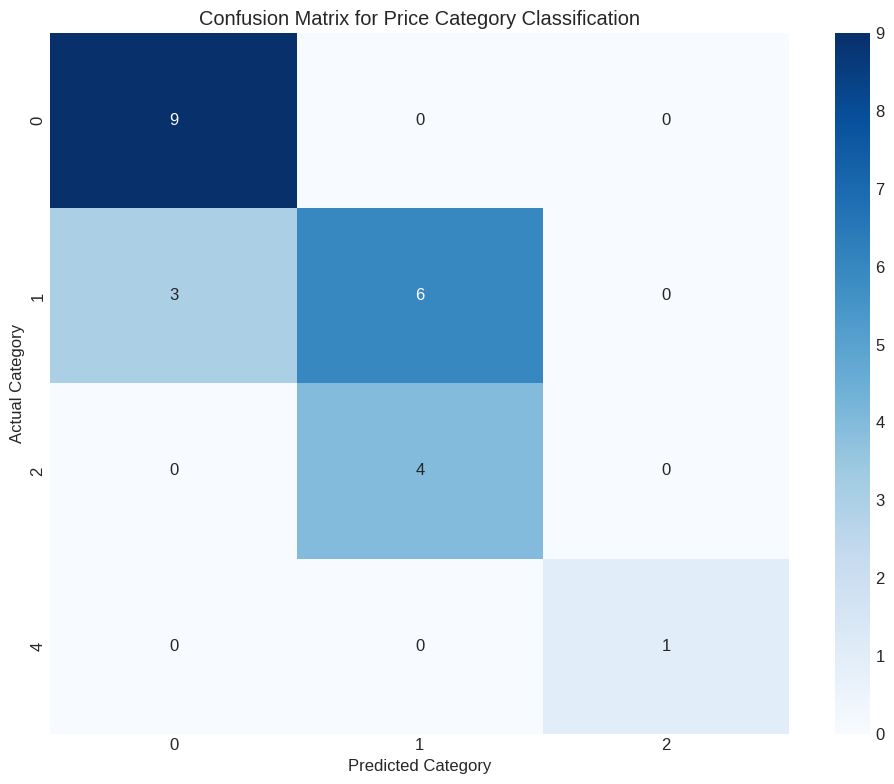

In [20]:
# Let's fix the confusion matrix visualization first
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Convert to pandas for visualization
conf_matrix_data = (rf_classifier_predictions
    .groupBy("price_category_idx", "prediction")
    .count()
    .toPandas())

# Create a pivot table for the confusion matrix
if conf_matrix_data.shape[0] > 0:  # Only if we have predictions
    # Convert indices to integers for proper pivoting
    conf_matrix_data['price_category_idx'] = conf_matrix_data['price_category_idx'].astype(int)
    conf_matrix_data['prediction'] = conf_matrix_data['prediction'].astype(int)

    # Create labels for confusion matrix
    category_labels = [category_mapping.get(i) for i in range(len(category_mapping))]

    # Create the confusion matrix
    conf_matrix = pd.pivot_table(
        conf_matrix_data,
        values='count',
        index='price_category_idx',
        columns='prediction',
        fill_value=0
    )

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".0f")  # Using .0f format for floats
    plt.title('Confusion Matrix for Price Category Classification')
    plt.xlabel('Predicted Category')
    plt.ylabel('Actual Category')
    plt.tight_layout()
    plt.show()



=== 3. Cryptocurrency Market Pattern Identification (Clustering) ===

Evaluating optimal number of clusters...
  k=2, Silhouette Score: 0.9168
  k=3, Silhouette Score: 0.7738
  k=4, Silhouette Score: 0.7905
  k=5, Silhouette Score: 0.5619
  k=6, Silhouette Score: 0.0362
  k=7, Silhouette Score: 0.4888

Optimal number of clusters: 2


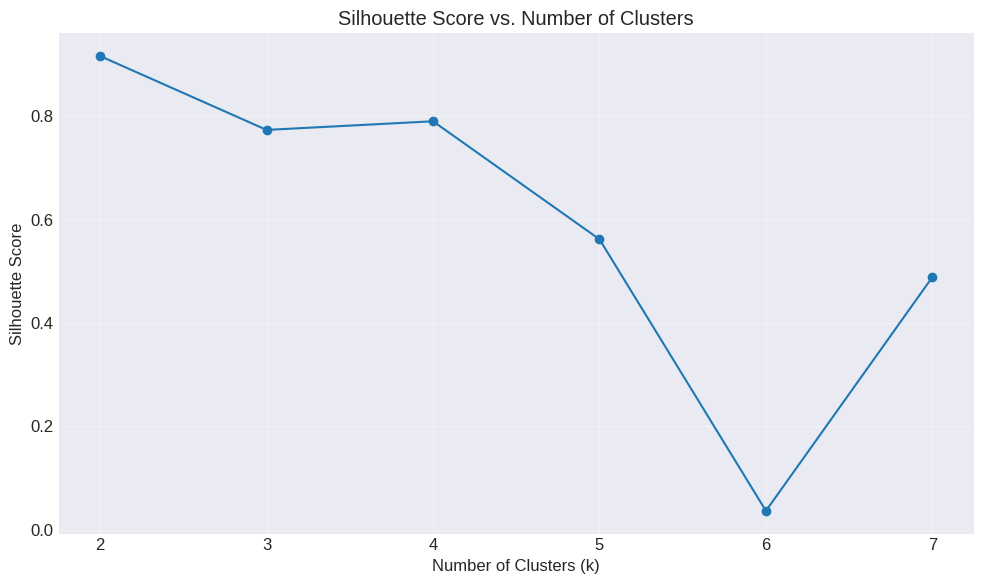

In [21]:
# 3. Clustering for Market Pattern Identification
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

print("\n=== 3. Cryptocurrency Market Pattern Identification (Clustering) ===")

# Determine optimal number of clusters using Silhouette score
silhouette_scores = []
k_values = range(2, 8)  # Test from 2 to 7 clusters

print("\nEvaluating optimal number of clusters...")
for k in k_values:
    # Create and train KMeans model
    kmeans = KMeans(
        featuresCol="scaled_features",
        predictionCol="cluster",
        k=k,
        seed=42
    )
    kmeans_model = kmeans.fit(clustering_df)

    # Make predictions
    predictions = kmeans_model.transform(clustering_df)

    # Evaluate
    evaluator = ClusteringEvaluator(
        featuresCol="scaled_features",
        predictionCol="cluster",
        metricName="silhouette"
    )
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    print(f"  k={k}, Silhouette Score: {silhouette:.4f}")


# Find optimal k with highest silhouette score
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [22]:

# Build final clustering model with optimal k
print(f"\nBuilding final KMeans clustering model with k={optimal_k}...")
kmeans_final = KMeans(
    featuresCol="scaled_features",
    predictionCol="cluster",
    k=optimal_k,
    seed=42
)
kmeans_model_final = kmeans_final.fit(clustering_df)

# Get cluster centers
centers = kmeans_model_final.clusterCenters()
print(f"Cluster Centers:")
for i, center in enumerate(centers):
    print(f"  Cluster {i}: [first 5 features: {', '.join([f'{c:.4f}' for c in center[:5]])}...]")

# Make predictions
cluster_predictions = kmeans_model_final.transform(clustering_df)

# Evaluate final model
final_silhouette = ClusteringEvaluator(
    featuresCol="scaled_features",
    predictionCol="cluster",
    metricName="silhouette"
).evaluate(cluster_predictions)

print(f"\nFinal Clustering Model:")
print(f"  Silhouette Score: {final_silhouette:.4f}")

# Analyze clusters
cluster_counts = cluster_predictions.groupBy("cluster").count().orderBy("cluster")
print("\nCluster Sizes:")
cluster_counts.show()

# Identify characteristics of each cluster
# Convert to pandas for easier analysis
cluster_analysis = cluster_predictions.select(
    "name", "symbol", "price", "market_cap", "volume_24h",
    "percent_change_24h", "percent_change_7d", "volatility_indicator", "cluster"
).toPandas()

# Calculate cluster statistics
cluster_stats = cluster_analysis.groupby('cluster').agg({
    'price': 'mean',
    'market_cap': 'mean',
    'volume_24h': 'mean',
    'percent_change_24h': 'mean',
    'percent_change_7d': 'mean',
    'volatility_indicator': 'mean'
}).reset_index()

print("\nCluster Statistics:")
display(cluster_stats)



Building final KMeans clustering model with k=2...
Cluster Centers:
  Cluster 0: [first 5 features: 0.0172, -0.0076, 0.0017, 0.0017, 0.0015...]
  Cluster 1: [first 5 features: -1.7062, 0.7489, -0.1718, -0.1724, -0.1517...]

Final Clustering Model:
  Silhouette Score: 0.9168

Cluster Sizes:
+-------+-----+
|cluster|count|
+-------+-----+
|      0|   99|
|      1|    1|
+-------+-----+


Cluster Statistics:


,cluster,price,market_cap,volume_24h,percent_change_24h,percent_change_7d,volatility_indicator
0,0,137.568471,1.215563e+10,2.610512e+09,0.663586,21.995634,24.650269
1,1,102969.105652,2.045372e+12,6.315628e+10,-0.903688,8.354442,9.258129



Top cryptocurrencies in each cluster (by market cap):

Cluster 0:


,name,symbol,price,market_cap,percent_change_7d,volatility_indicator
1,Ethereum,ETH,2491.350123,3.007800e+11,36.465978,37.148755
2,Tether USDt,USDT,1.000019,1.500595e+11,-0.004223,0.022155
3,XRP,XRP,2.533274,1.483243e+11,18.050787,25.007099



Cluster 1:


,name,symbol,price,market_cap,percent_change_7d,volatility_indicator
0,Bitcoin,BTC,102969.105652,2.045372e+12,8.354442,9.258129


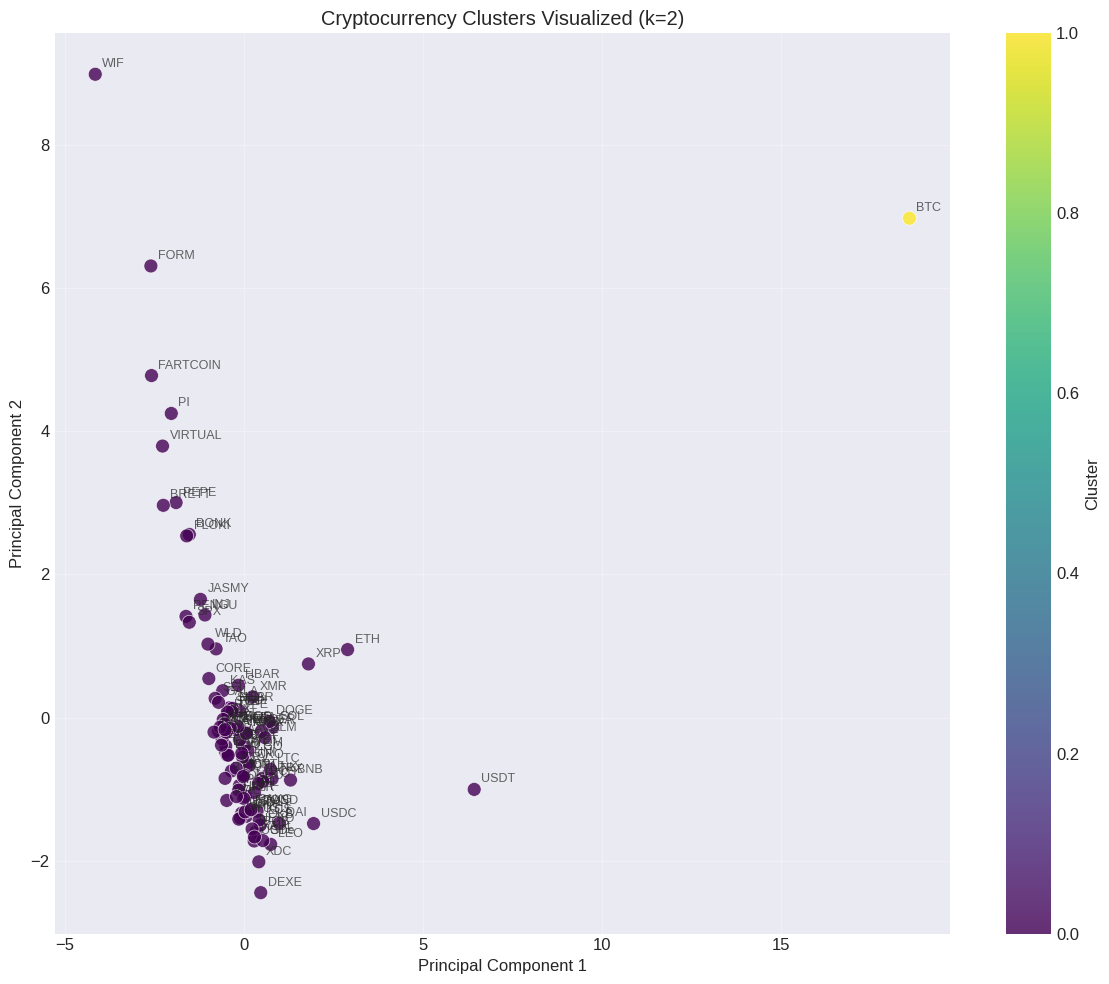

In [23]:

# Show examples from each cluster
print("\nTop cryptocurrencies in each cluster (by market cap):")
for cluster_id in range(optimal_k):
    cluster_examples = cluster_analysis[cluster_analysis['cluster'] == cluster_id]
    top_examples = cluster_examples.sort_values(by='market_cap', ascending=False).head(3)
    print(f"\nCluster {cluster_id}:")
    display(top_examples[['name', 'symbol', 'price', 'market_cap', 'percent_change_7d', 'volatility_indicator']])

# Visualize clusters using 2D projection
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality for visualization
# Convert feature vectors to numpy arrays
feature_vectors = np.array([r.scaled_features.toArray() for r in cluster_predictions.select("scaled_features").collect()])
clusters = np.array([r.cluster for r in cluster_predictions.select("cluster").collect()])
names = np.array([r.symbol for r in cluster_predictions.select("symbol").collect()])

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(feature_vectors)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data={'x': pca_result[:, 0], 'y': pca_result[:, 1], 'cluster': clusters, 'name': names})

# Plot the clusters
plt.figure(figsize=(12, 10))
scatter = plt.scatter(pca_df['x'], pca_df['y'], c=pca_df['cluster'], cmap='viridis',
                     s=100, alpha=0.8, edgecolors='w', linewidth=0.5)

# Add cryptocurrency symbols as annotations
for i, txt in enumerate(pca_df['name']):
    plt.annotate(txt, (pca_df['x'][i], pca_df['y'][i]),
                fontsize=9, alpha=0.7,
                xytext=(5, 5), textcoords='offset points')

plt.title(f'Cryptocurrency Clusters Visualized (k={optimal_k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=cluster_stats)

https://docs.google.com/spreadsheets/d/11D6NEc7ECQPYkwkB2dZGEdXqU4FBIiodqDXIgIK7nDs/edit#gid=0


In [25]:
# prompt: code to download this pynb file as a html file with all the outputs

!jupyter nbconvert --to html /content/drive/MyDrive/your_notebook_name.ipynb


[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/your_notebook_name.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Time Series Trend Modeling with Window Functions

In [32]:
from pyspark.sql.window import Window
from pyspark.sql import functions as F

windowSpec = Window.orderBy("last_updated")

df_spark = df_spark.withColumn("price_lag_1", F.lag("price", 1).over(windowSpec))
df_spark = df_spark.withColumn("price_change", F.col("price") - F.col("price_lag_1"))

df_spark.select("name", "price", "price_lag_1", "price_change").show(10)


+----------------+-------------------+-------------------+--------------------+
|            name|              price|        price_lag_1|        price_change|
+----------------+-------------------+-------------------+--------------------+
|     Tether USDt| 1.0000194977165537|               NULL|                NULL|
|          Solana| 173.83779223939942| 1.0000194977165537|  172.83777274168287|
|            USDC| 0.9999913641918655| 173.83779223939942| -172.83780087520756|
|            TRON|0.27133921724409726| 0.9999913641918655| -0.7286521469477683|
|          Hedera|0.21675689205086657|0.27133921724409726|-0.05458232519323...|
|         Toncoin|  3.345021132412062|0.21675689205086657|   3.128264240361195|
|     Hyperliquid| 24.832357912302424|  3.345021132412062|  21.487336779890363|
|            Ondo| 1.0285266201431584| 24.832357912302424| -23.803831292159266|
|Ethereum Classic| 19.798696513264012| 1.0285266201431584|  18.770169893120855|
|          Render|  5.185397310942046| 1

 Feature Importance from Random Forest

In [34]:
from pyspark.ml.feature import VectorAssembler

# Step 1: Select feature columns and label
feature_cols = ['price', 'volume_24h', 'circulating_supply', 'num_market_pairs']  # Example columns
label_col = 'market_cap'

# Step 2: Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(df_spark)

# Step 3: Filter out rows with nulls in label or features
final_data = assembled_data.select("features", label_col).na.drop()


In [35]:
from pyspark.ml.regression import RandomForestRegressor

rf_model = RandomForestRegressor(featuresCol="features", labelCol="market_cap")
model = rf_model.fit(final_data)
importances = model.featureImportances

feature_names = assembler.getInputCols()
for name, importance in zip(feature_names, importances):
    print(f"{name}: {importance}")


price: 0.16421097596758863
volume_24h: 0.5055129379723605
circulating_supply: 0.15057834815040377
num_market_pairs: 0.1796977379096471


 Simulated Streaming Input for Real-Time Predictions

In [40]:
from pyspark.sql.types import StructType

# 1. Make sure streaming folder exists
import os
os.makedirs("/content/streaming_folder", exist_ok=True)

# 2. Add one simulated JSON file (if not already present)
import json
from datetime import datetime

sample_data = df_spark.limit(5).toPandas().to_dict(orient="records")
filename = f"/content/streaming_folder/crypto_snapshot_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(filename, "w") as f:
    json.dump(sample_data, f)

# 3. Read from folder as streaming DataFrame
stream_df = spark.readStream.schema(df_spark.schema).option("maxFilesPerTrigger", 1).json("/content/streaming_folder")

# 4. Print to console
query = stream_df.writeStream.outputMode("append").format("console").start()

# 5. Let it run for 30 seconds then stop
query.awaitTermination(30)
query.stop()


 Anomaly Detection on Price Changes

In [41]:

stats = df_spark.select(F.mean("price_change"), F.stddev("price_change")).first()
mean_val, std_val = stats[0], stats[1]
df_spark = df_spark.withColumn("z_score", (F.col("price_change") - mean_val) / std_val)
anomalies = df_spark.filter(F.abs(F.col("z_score")) > 3)
anomalies.select("name", "price_change", "z_score").show()


+--------+-------------------+------------------+
|    name|       price_change|           z_score|
+--------+-------------------+------------------+
| Bitcoin|  99733.32594131044| 6.965937119086108|
|Ethereum|-100477.75552895623|-7.017931949063654|
+--------+-------------------+------------------+



 Join with Simulated News Sentiment Data

In [43]:
#Simulate external sentiment data (this can later be replaced with real API sentiment scores)
sentiment_data = spark.createDataFrame([
    ("Bitcoin", 0.8),
    ("Ethereum", 0.5),
    ("XRP", -0.3)
], ["name", "sentiment_score"])

#Join with your existing DataFrame (assuming it's called df_spark and has 'name' and 'price' columns)
joined_df = df_spark.join(sentiment_data, on="name", how="left")

#Show only selected columns to avoid clutter
joined_df.select("name", "price", "market_cap", "sentiment_score").show(truncate=False)


+------------+-------------------+---------------------+---------------+
|name        |price              |market_cap           |sentiment_score|
+------------+-------------------+---------------------+---------------+
|Stellar     |0.31431685114732155|9.76322589681417E9   |NULL           |
|Ethereum    |2491.350123073523  |3.0078004822670825E11|0.5            |
|Avalanche   |24.932636989132508 |1.0432452013854498E10|NULL           |
|Toncoin     |3.345021132412062  |8.329684895817174E9  |NULL           |
|Chainlink   |16.74616319670667  |1.1003903341753498E10|NULL           |
|Pi          |1.2149548557036833 |8.605237303248898E9  |NULL           |
|Hyperliquid |24.832357912302424 |8.292224082763748E9  |NULL           |
|USDC        |0.9999913641918655 |6.089164218202023E10 |NULL           |
|Solana      |173.83779223939942 |9.029913141443695E10 |NULL           |
|Tether USDt |1.0000194977165537 |1.500594937132614E11 |NULL           |
|Polkadot    |5.086408141401943  |8.020098838376145

 Save Final Output to Hive or Parquet

In [44]:

df_spark.write.mode("overwrite").parquet("/content/crypto_output.parquet")


 Simple Content-Based Recommendation System

In [49]:
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType

# Optional: define cosine similarity between scaled feature vectors
def cosine_similarity(v1, v2):
    v1 = DenseVector(v1)
    v2 = DenseVector(v2)
    return float(v1.dot(v2) / (v1.norm(2) * v2.norm(2)))

cosine_udf = udf(cosine_similarity, DoubleType())

# Instead of using spark_df, use clustering_df which contains 'features' and 'scaled_features'
scaled_df = clustering_df.select("name", "features", "market_cap", "scaled_features")

# Join on all coin pairs with different names
similarity = scaled_df.alias("a").join(
    scaled_df.alias("b"),
    col("a.name") != col("b.name")
)

# Compute cosine similarity score
similarity = similarity.withColumn(
    "similarity_score",
    cosine_udf(col("a.scaled_features"), col("b.scaled_features"))
)

# Show top recommendations (most similar coins)
similarity.select(
    col("a.name").alias("Coin A"),
    col("b.name").alias("Recommended Similar Coin"),
    col("similarity_score")
).orderBy(col("similarity_score").desc()).show(10, truncate=False)

+-----------------+------------------------+------------------+
|Coin A           |Recommended Similar Coin|similarity_score  |
+-----------------+------------------------+------------------+
|Dai              |First Digital USD       |0.9612095562970464|
|First Digital USD|Dai                     |0.9612095562970464|
|Ethereum Classic |Filecoin                |0.9391395789725432|
|Filecoin         |Ethereum Classic        |0.9391395789725432|
|Quant            |IOTA                    |0.9234969171521542|
|IOTA             |Quant                   |0.9234969171521542|
|Nexo             |Bitcoin SV              |0.9166772139831896|
|Bitcoin SV       |Nexo                    |0.9166772139831896|
|Mantle           |POL (prev. MATIC)       |0.9158571380762329|
|POL (prev. MATIC)|Mantle                  |0.9158571380762329|
+-----------------+------------------------+------------------+
only showing top 10 rows

